In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
import alpaca_trade_api as tradeapi

In [4]:
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
list_of_tickers = ["AGG", "SPY"]
# YOUR CODE HERE
timeframe = '1D'


end_date = datetime.now()
start_date = end_date + timedelta(-365)


df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)


df.head()

,AGG,SPY
,close,close
time,,
2019-11-22 00:00:00-05:00,112.850,311.00
2019-11-25 00:00:00-05:00,112.980,313.35
2019-11-26 00:00:00-05:00,113.120,314.02
2019-11-27 00:00:00-05:00,112.995,315.46
2019-11-29 00:00:00-05:00,112.925,314.27


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [6]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE
daily_returns = df.pct_change()


avg_daily_returns_agg = daily_returns.mean()['AGG']
avg_daily_returns_spy = daily_returns.mean()['SPY']

daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-11-22 00:00:00-05:00,NaN,NaN
2019-11-25 00:00:00-05:00,0.001152,0.007556
2019-11-26 00:00:00-05:00,0.001239,0.002138
2019-11-27 00:00:00-05:00,-0.001105,0.004586
2019-11-29 00:00:00-05:00,-0.000619,-0.003772


In [7]:
# Calculate volatility
# YOUR CODE HERE
std_dev_daily_returns_agg = daily_returns.std()['AGG']['close']
std_dev_daily_returns_spy = daily_returns.std()['SPY']['close']

print(f"Volatlity for AGG is {std_dev_daily_returns_agg}.")
print(f"Volatlity for SPY is {std_dev_daily_returns_spy}.")

Volatlity for AGG is 0.008495315735196624.
Volatlity for SPY is 0.030315930449348896.


In [8]:
# Save the last day's closing price
# YOUR CODE HERE
agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]

print(f"Last day's closing price for AGG is {agg_last_price}.")
print(f"Last day's closing price for SPY is {spy_last_price}.")

Last day's closing price for AGG is 117.22.
Last day's closing price for SPY is 286.73.


In [9]:
# Setup the Monte Carlo Parameters
num_simulations = 100
num_records = 252 * 3
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [10]:
# Run the Monte Carlo Simulation
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `TSLA` and `SPHD`
    simulated_agg_prices = [agg_last_price]
    simulated_spy_prices = [spy_last_price]
    
    # Simulate the returns for 252 * 3 days
    for i in range(num_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_returns_agg, std_dev_daily_returns_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_returns_spy, std_dev_daily_returns_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    # Append a simulated prices of each simulation to DataFrame
    
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    simulated_daily_returns = simulated_daily_returns.astype(float)
    
    # Set the portfolio weights (75% TSLA; 25% SPHD)
    weights = [0.40, 0.60]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999124,0.963564,0.986530,0.995170,0.979718,0.974214,1.021627,0.974038,0.993574,0.973751,...,0.979262,0.975751,0.996731,0.995547,0.953927,1.013466,0.998833,0.984275,0.991476,0.986133
2,1.028953,0.961112,0.995182,1.008251,1.002433,0.992852,1.057380,0.982424,0.998851,0.959451,...,0.967878,0.982608,0.970631,0.993700,0.939699,1.030279,0.999922,0.976167,1.024071,0.943552
3,1.023702,0.977036,0.994032,1.040312,1.016726,0.962947,1.033914,0.977095,0.976562,0.943394,...,0.996522,1.008164,0.952910,1.008757,0.950203,1.009317,0.991939,0.965141,1.040181,0.930061
4,1.043436,1.006539,0.973677,1.022514,1.045601,0.940270,0.998454,0.969527,0.995775,0.953651,...,1.011705,1.014236,0.997588,1.019821,0.953098,0.993937,1.028861,0.927450,1.027228,0.946512


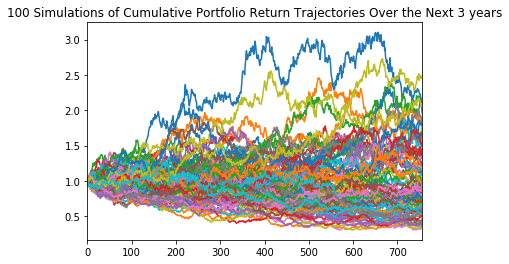

In [11]:
# Visualize the Simulation
# YOUR CODE HERE
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 3 years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [12]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    1.880205
1    1.345524
2    0.416332
3    0.449678
4    0.552889
Name: 756, dtype: float64

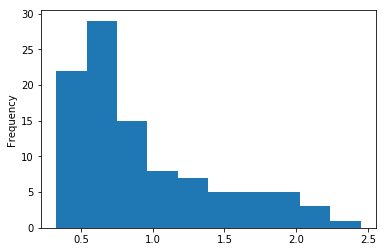

In [13]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
ending_cumulative_returns.plot(kind='hist', bins=10)

In [14]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
confidence_interval_90 = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval_90

0.05    0.378850
0.95    1.889145
Name: 756, dtype: float64

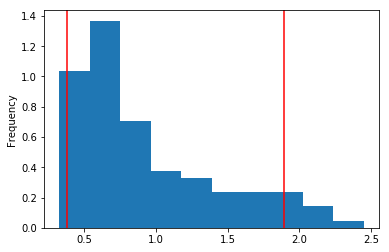

In [15]:
# Visualize the distribution of the ending returns
# YOUR CODE HERE
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval_90.iloc[0], color='r')
plt.axvline(confidence_interval_90.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [16]:
# YOUR CODE HERE
confidence_interval_10 = ending_cumulative_returns.quantile(q=[0.45, 0.55])
confidence_interval_10

confidence_interval_50 = ending_cumulative_returns.quantile(q=[0.25, 0.75])
confidence_interval_50

confidence_interval_90 = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval_90

expected_cum_returns = ending_cumulative_returns.quantile(q=[0.1, 0.5, 0.9])

print(expected_cum_returns)

0.1    0.447819
0.5    0.747270
0.9    1.715942
Name: 756, dtype: float64


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [17]:
# YOUR CODE HERE
initial_investment = 20000

investment_pnl_lower_bound_10 = initial_investment * confidence_interval_10.iloc[0]
investment_pnl_upper_bound_10 = initial_investment * confidence_interval_10.iloc[1]

investment_pnl_lower_bound_50 = initial_investment * confidence_interval_50.iloc[0]
investment_pnl_upper_bound_50 = initial_investment * confidence_interval_50.iloc[1]

investment_pnl_lower_bound_90= initial_investment * confidence_interval_90.iloc[0]
investment_pnl_upper_bound_90 = initial_investment * confidence_interval_90.iloc[1]
                                                    
# Print the results
print(f"There is a 10% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 252 * 3 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound_10} and ${investment_pnl_upper_bound_10}")
print()
print(f"There is a 50% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 252 * 3 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound_50} and ${investment_pnl_upper_bound_50}")
print()
print(f"There is a 90% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 252 * 3 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound_90} and ${investment_pnl_upper_bound_90}")
                                                    

There is a 10% chance that an initial investment of $20,000 in the portfolio over the next 252 * 3 trading days will end within in the range of $14516.441015812185 and $15981.244529441314

There is a 50% chance that an initial investment of $20,000 in the portfolio over the next 252 * 3 trading days will end within in the range of $11470.10338595098 and $24686.545115686105

There is a 90% chance that an initial investment of $20,000 in the portfolio over the next 252 * 3 trading days will end within in the range of $7576.996745766961 and $37782.900450511166


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [18]:
# YOUR CODE HERE

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [19]:
# YOUR CODE HERE

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [20]:
# YOUR CODE HERE